# Benchmarking a TCR embedder model

## Importing modules and data

In [1]:
import sys
import os
sys.path.append('/home/yutanagano/Projects/tcr_embedder')
os.chdir('/home/yutanagano/Projects/tcr_embedder')

In [2]:
import json
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from src.datahandling.dataloaders import TCRDataLoader
from src.datahandling.datasets import TCRDataset
from src.datahandling.tokenisers import CDR3Tokeniser
from src import modules
from src import metrics
import torch
from tqdm import tqdm

seaborn.set_theme()
seaborn.set_style('white')

In [3]:
tanno_et_al_test_subset = pd.read_csv('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/tanno/test.csv').iloc[:10000]

back_ds = TCRDataset(
    data=tanno_et_al_test_subset,
    tokeniser=CDR3Tokeniser()
)

ep_ds = TCRDataset(
    data='/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/data/preprocessed/vdjdb/evaluation.csv',
    tokeniser=CDR3Tokeniser()
)

In [4]:
back_dl = TCRDataLoader(dataset=back_ds, batch_size=512, shuffle=False)
ep_dl = TCRDataLoader(dataset=ep_ds, batch_size=512, shuffle=False)

### Load model

In [5]:
model_save_dir = Path('/home/yutanagano/UCLOneDrive/MBPhD/projects/tcr_embedder/model_saves/CDR3BERT_a')
with open(model_save_dir/'config.json', 'r') as f:
    config = json.load(f)
model = modules.CDR3BERT_a(
    **config['model']['config']
)
model.load_state_dict(torch.load(model_save_dir/'state_dict.pt'))
model.eval()

# model = modules.AtchleyEmbedder()

CDR3BERT_a(
  (encoder_stack): TransformerEncoder(
    (layers): ModuleList(
      (0): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=512, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
      (1): TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=512, bias=True)
        (dropout): Dropout(p=0.1, 

### Create benchmarking directory

In [6]:
BENCHMARK_DIR = Path(f'benchmarks/{model.name}')
if not BENCHMARK_DIR.is_dir():
    BENCHMARK_DIR.mkdir()

In [7]:
model.name

'CDR3BERT_a_6_128_8_512-embed_5'

## Use model to embed TCRs

In [8]:
with torch.no_grad():
    back_embs = [model.embed(x) for x in tqdm(back_dl)]
    back_embs = torch.concat(back_embs)

100%|██████████| 20/20 [00:08<00:00,  2.35it/s]


In [9]:
with torch.no_grad():
    ep_embs = [model.embed(x) for x in tqdm(ep_dl)]
    ep_embs = torch.concat(ep_embs)

100%|██████████| 10/10 [00:04<00:00,  2.47it/s]


## Fit a PCA to the background TCR (Tanno et al.) data

In [10]:
pca = PCA()
pca.fit(back_embs)

PCA()

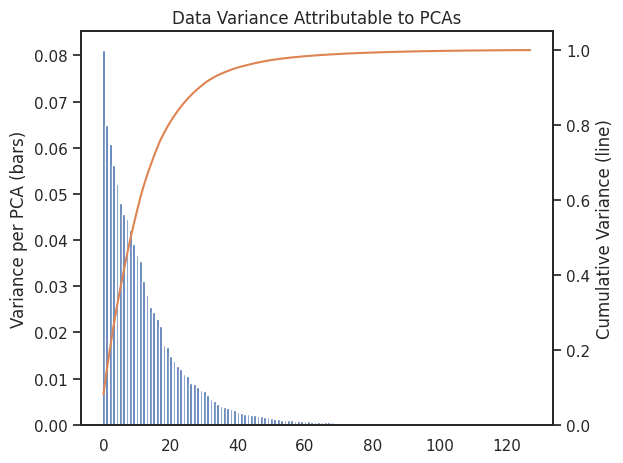

In [11]:
# Display ratios of variance explained by each of the PCAs
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

pca_summary = plt.figure()

ax = plt.axes()
ax.set_title('Data Variance Attributable to PCAs')
ax.set_ylabel('Variance per PCA (bars)')

axd = ax.twinx()
axd.set_ylabel('Cumulative Variance (line)')
axd.set_ylim(0,1.05)

ax.bar(range(pca.n_components_), pca.explained_variance_ratio_)
axd.plot(cumulative_variance, c='C1')

plt.tight_layout()
plt.savefig(BENCHMARK_DIR/'pca.png')
plt.show()

### Visualise TCR distribution in embedding space

In [12]:
background = pca.transform(back_embs)[:,:2]
epitope_labeled = pca.transform(ep_embs)[:,:2]

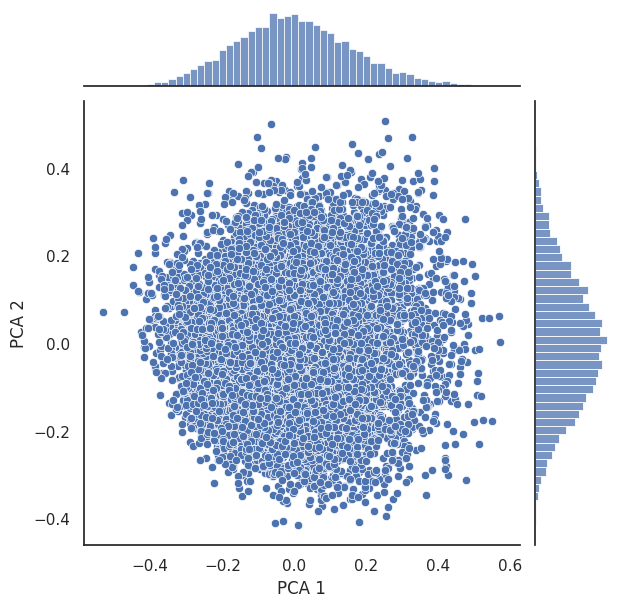

In [13]:
bg_viz = seaborn.jointplot(x=background[:,0], y=background[:,1])

ylim = bg_viz.ax_joint.get_ylim()
xlim = bg_viz.ax_joint.get_xlim()

bg_viz.set_axis_labels(xlabel='PCA 1', ylabel='PCA 2')
bg_viz.savefig(BENCHMARK_DIR/'bg_viz.png')
plt.show()

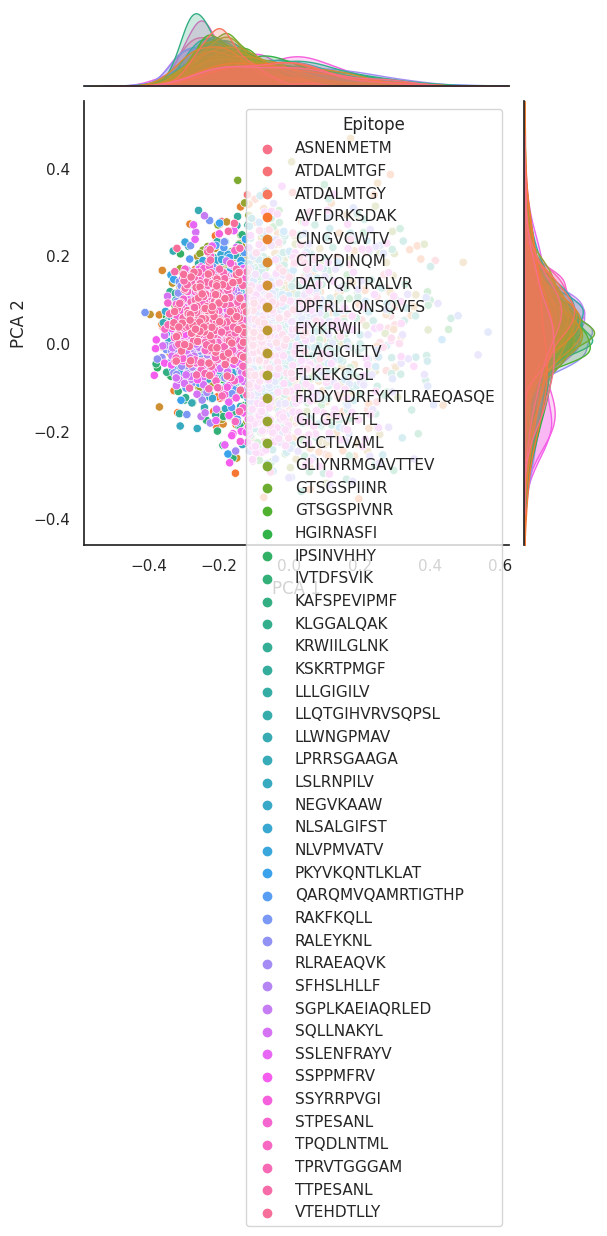

In [14]:
ep_viz = seaborn.jointplot(x=epitope_labeled[:,0], y=epitope_labeled[:,1], xlim=xlim, ylim=ylim, hue=ep_ds._data['Epitope'])
ep_viz.set_axis_labels(xlabel='PCA 1', ylabel='PCA 2')
ep_viz.savefig(BENCHMARK_DIR/'ep_viz.png')
plt.show()

## Calculate alignment and uniformity

In [15]:
epitope_cat_codes = torch.tensor(ep_ds._data['Epitope'].astype('category').cat.codes)

In [16]:
alignment = metrics.alignment(ep_embs, epitope_cat_codes).item()

In [17]:
uniformity = metrics.uniformity(ep_embs).item()

## k-NN evaluation of embeddings

In [18]:
scores = []
ep_len = len(ep_embs)

for i in tqdm(range(ep_len)):
    filt = torch.ones(ep_len, dtype=torch.bool)
    filt[i] = False

    loo_embs = ep_embs[filt]
    loo_cat_codes = epitope_cat_codes[filt]

    test_emb = ep_embs[[i]]
    expected_cat_code = epitope_cat_codes[[i]]

    knn = KNeighborsClassifier()
    knn.fit(loo_embs, loo_cat_codes)

    scores.append(knn.predict(test_emb).item() == expected_cat_code.item())

knn_accuracy = torch.tensor(scores, dtype=torch.float32).mean().item()

100%|██████████| 4800/4800 [03:46<00:00, 21.19it/s]


## Write out evaluation metrics to json

In [19]:
metrics_dict = {
    'model_name': model.name,
    'alignment': alignment,
    'uniformity': uniformity,
    'alignment + uniformity': alignment + uniformity,
    '5nn_accuracy': knn_accuracy
}

In [20]:
with open(BENCHMARK_DIR/'metrics.json', 'w') as f:
    json.dump(metrics_dict, f, indent=4)